# Урок 7. Рекурентные сети для обработки последовательностей
# Домашнее задание

1. Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/LV1cYS1orMyRWA

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Скачаем датасет с каггла:

In [2]:
! kaggle datasets download arkhoshghalb/twitter-sentiment-analysis-hatred-speech

  0% 0.00/1.89M [00:00<?, ?B/s]
100% 1.89M/1.89M [00:00<00:00, 213MB/s]


In [3]:
! unzip twitter-sentiment-analysis-hatred-speech.zip

Archive:  twitter-sentiment-analysis-hatred-speech.zip
  inflating: test.csv                
  inflating: train.csv               


In [4]:
!pip install stop-words pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.4 MB/s 
     |████████████████████████████████| 8.2 MB 47.2 MB/s 
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=8d364c0c407635709cd81798d6d0efb1ab09dc8523fe523fd2912f7ee02ff6ab
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


Скачаем библиотеку для лемматизации английских слов:

In [5]:
! pip install spacy
! spacy download en

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.0 MB 18.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


Установим необхидимые библиотеки:

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re
import spacy
from tqdm import tqdm 
tqdm.pandas()
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")
from nltk.probability import FreqDist
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
df = pd.read_csv("train.csv")

Посмотрим датасет:

In [8]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [9]:
df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

Распределение лейблов очень неравномерное.

Разобьем датасет, используя стратификацию:

In [10]:
df_train, df_test = train_test_split(df, test_size=0.3, shuffle=True, stratify=df['label'], random_state=42)

In [11]:
df_test['label'].value_counts()

0    8916
1     673
Name: label, dtype: int64

Подготовим функцию для обработки текста с лемматизацией:

In [12]:
sw = set(get_stop_words("english"))
puncts = set(punctuation)
nlp = spacy.load('en', disable=['parser', 'ner'])

def preprocess_text(txt):
  txt = str(txt)
  txt = "".join(c for c in txt if c not in puncts)
  txt = txt.lower()
  txt = re.sub("not\s", "not", txt)
  txt = re.sub("dont\s", "dont", txt)
  txt = re.sub("doesnt\s", "doesnt", txt)
  txt = re.sub("didnt\s", "didnt", txt)
  txt = re.sub("havent\s", "havent", txt)
  txt = re.sub("hasnt\s", "hasnt", txt)
  txt = nlp(txt)
  txt = [word.lemma_ for word in txt if word not in sw]
  return " ".join(txt)

In [13]:
df_train['tweet'].iloc[:1].values

array(['happy bihday to my brother man. needed this mixtape like we need boos. have a good one sach   @user '],
      dtype=object)

In [14]:
df_train['tweet'].iloc[:1].apply(preprocess_text).values

array(['happy bihday to -PRON- brother man need this mixtape like -PRON- need boo have a good one sach    user'],
      dtype=object)

Применим обработку текста с лемматизацией к трейну и тесту:

In [15]:
df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_test['tweet'] = df_test['tweet'].progress_apply(preprocess_text)

100%|██████████| 9589/9589 [00:23<00:00, 401.89it/s]


Составим корпус текстов:

In [16]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

Инициализируем функцию токенизации:

In [17]:
def text_to_sequence(text, maxlen, vocabulary):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

Инициализируем сеть LSTM:

In [18]:
class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

Инициализируем сеть GRU:

In [19]:
class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

Инициализируем класс кастомного датасета:

In [20]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

Инициализируем функцию подготовки загрузчиков:

In [21]:
def get_loaders(max_words=2000, max_len=20):

  tokens = word_tokenize(train_corpus)
  tokens_filtered = [word for word in tokens if word.isalnum()]
  dist = FreqDist(tokens_filtered)
  tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]
  vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
  
  x_train = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_train["tweet"]])
  x_test = np.asarray([text_to_sequence(text, max_len, vocabulary) for text in df_test["tweet"]])

  train_dataset = DataWrapper(x_train, df_train['label'].values)
  train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

  test_dataset = DataWrapper(x_test, df_test['label'].values)
  test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
  return train_loader, test_loader

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Инициализируем функцию обучения модели:

In [57]:
def learn_net(model, epochs=20, th=0.5):
  model = model.to(device)
  model.train()
  
  train_loss_history = []
  test_loss_history = []
  train_f1_history = []
  test_f1_history = []

  for epoch in range(epochs):  
      running_loss, test_loss = 0.0, 0.0
      tp_train, tn_train, fp_train, fn_train = 0.0, 0.0, 0.0, 0.0
      tp_test, tn_test, fp_test, fn_test = 0.0, 0.0, 0.0, 0.0
      pr_train, rec_train = 0.0, 0.0
      pr_test, rec_test = 0.0, 0.0
      f1_score_train, f1_score_test = 0.0, 0.0
      for i, data in enumerate(train_loader, 0):
          inputs, labels = data[0].to(device), data[1].to(device)
          
          # обнуляем градиент
          optimizer.zero_grad()
          outputs = model(inputs)
          
          loss = criterion(outputs, labels.float().view(-1, 1))
          loss.backward()
          optimizer.step()

          # подсчет ошибки на обучении
          running_loss += loss.item()
          # подсчет метрики на обучении
          pred_labels = torch.squeeze((outputs > th).int())
          tp_train += ((labels == pred_labels) & (labels == 1)).sum().item()
          tn_train += ((labels == pred_labels) & (labels == 0)).sum().item()
          fp_train += ((labels != pred_labels) & (labels == 0)).sum().item()
          fn_train += ((labels != pred_labels) & (labels == 1)).sum().item()
          
      # выводим статистику о процессе обучения
      model.eval()
      pr_train = tp_train / (tp_train + fp_train + .001)
      rec_train = tp_train / (tp_train + fn_train + .001)
      f1_score_train = 2 * pr_train * rec_train / (pr_train + rec_train + .001)
      print(f'Epoch [{epoch + 1}/{epochs}]. ' \
              f'Step [{i + 1}/{len(train_loader)}]. ' \
              f'Loss: {running_loss/(i+1):.3f}. ' \
              f'F1: {f1_score_train:.3f}', end='. ')
      
      train_loss_history.append(running_loss/(i+1))
      train_f1_history.append(f1_score_train)
      running_loss = 0.0
      tp_train, tn_train, fp_train, fn_train = 0.0, 0.0, 0.0, 0.0
      pr_train, rec_train = 0.0, 0.0
      f1_score_train = 0.0

          # выводим статистику на тестовых данных
      for j, data in enumerate(test_loader):
          test_labels = data[1].to(device)
          test_outputs = model(data[0].to(device))
          
          # подсчет ошибки на тесте
          test_loss += criterion(test_outputs, test_labels.float().view(-1, 1))
          # подсчет метрики на тесте
          pred_test_labels = torch.squeeze((test_outputs > th).int())
          tp_test += ((test_labels == pred_test_labels) & (test_labels == 1)).sum().item()
          tn_test += ((test_labels == pred_test_labels) & (test_labels == 0)).sum().item()
          fp_test += ((test_labels != pred_test_labels) & (test_labels == 0)).sum().item()
          fn_test += ((test_labels != pred_test_labels) & (test_labels == 1)).sum().item()
      
      pr_test = tp_test / (tp_test + fp_test + .001)
      rec_test = tp_test / (tp_test + fn_test + .001)
      f1_score_test = 2 * pr_test * rec_test / (pr_test + rec_test + .001)
      test_loss_history.append(test_loss.item()/(j+1))
      test_f1_history.append(f1_score_test)
      print(f'Test loss: {test_loss/(j+1):.3f}. Test F1: {f1_score_test:.3f}')
      test_loss = 0.0
      tp_test, tn_test, fp_test, fn_test = 0.0, 0.0, 0.0, 0.0
      pr_test, rec_test = 0.0, 0.0
      f1_score_test = 0.0

      model.train()
          
  print('Training is finished!')
  return train_loss_history, test_loss_history, train_f1_history, test_f1_history

Проведем эксперимент, для начала с GRU. Для рекуррентных сетей очень важна длина поступающей последовательности, поэтому начнем с разных длин последовательности:

In [26]:
losses_train = []
losses_test = []
f1_list_train = []
f1_list_test = []
for i in [5, 10, 15, 20]:
  train_loader, test_loader = get_loaders(max_words=2000, max_len=i)
  model = GRUFixedLen(vocab_size=2000)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = nn.BCELoss()
  train_loss_history, test_loss_history, train_f1_history, test_f1_history = learn_net(model)
  losses_train.append(train_loss_history)
  losses_test.append(test_loss_history)
  f1_list_train.append(train_f1_history)
  f1_list_test.append(test_f1_history)

Epoch [1/20]. Step [44/44]. Loss: 0.237. F1: 0.222. Test loss: 0.178. Test F1: 0.386
Epoch [2/20]. Step [44/44]. Loss: 0.157. F1: 0.477. Test loss: 0.165. Test F1: 0.471
Epoch [3/20]. Step [44/44]. Loss: 0.126. F1: 0.601. Test loss: 0.167. Test F1: 0.492
Epoch [4/20]. Step [44/44]. Loss: 0.102. F1: 0.685. Test loss: 0.180. Test F1: 0.557
Epoch [5/20]. Step [44/44]. Loss: 0.083. F1: 0.767. Test loss: 0.192. Test F1: 0.510
Epoch [6/20]. Step [44/44]. Loss: 0.068. F1: 0.808. Test loss: 0.222. Test F1: 0.538
Epoch [7/20]. Step [44/44]. Loss: 0.056. F1: 0.847. Test loss: 0.228. Test F1: 0.554
Epoch [8/20]. Step [44/44]. Loss: 0.046. F1: 0.877. Test loss: 0.242. Test F1: 0.541
Epoch [9/20]. Step [44/44]. Loss: 0.041. F1: 0.896. Test loss: 0.246. Test F1: 0.550
Epoch [10/20]. Step [44/44]. Loss: 0.038. F1: 0.903. Test loss: 0.280. Test F1: 0.556
Epoch [11/20]. Step [44/44]. Loss: 0.034. F1: 0.912. Test loss: 0.285. Test F1: 0.524
Epoch [12/20]. Step [44/44]. Loss: 0.033. F1: 0.916. Test loss:

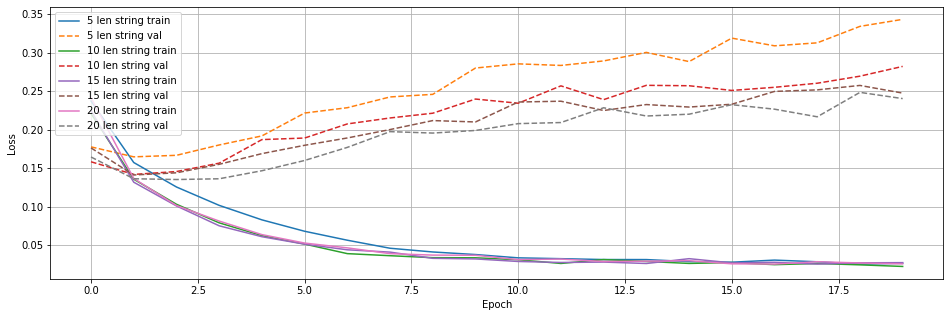

In [27]:
plt.figure(figsize = (16,5))
for i in range(4):
    plt.plot(losses_train[i],'-',label = f'{(i + 1) * 5} len string train')
    plt.plot(losses_test[i],'--',label = f'{(i + 1) * 5} len string val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show() 

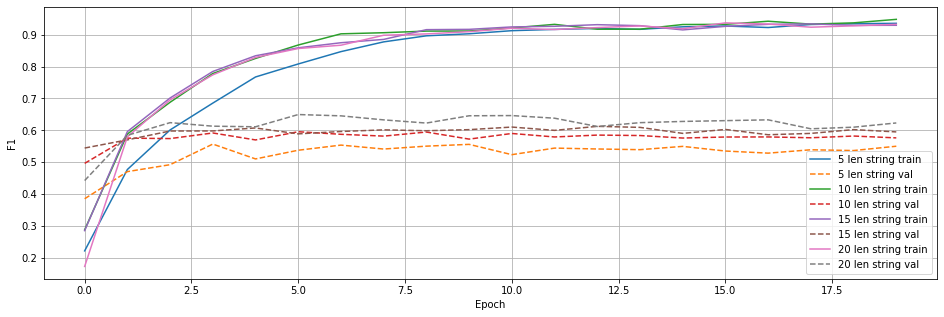

In [28]:
plt.figure(figsize = (16,5))
for i in range(4):
    plt.plot(f1_list_train[i],'-',label = f'{(i + 1) * 5} len string train')
    plt.plot(f1_list_test[i],'--',label = f'{(i + 1) * 5} len string val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid()
plt.show() 

Модель сильно переобучается, лосс на тесте растет. По метрике лучше себя показывает входная последовательность в 20 токенов. 

Теперь попробуем применить слой дропаут для выходного полносвязного слоя:

In [50]:
class GRUFixedLen2(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        out = self.dropout(out)
        # print(out.shape)
        return torch.sigmoid(out)

Также в эксперименте попробуем 2 варианта - взятие последнего выхода рекуррентного слоя или их усреднение:

In [51]:
losses_train = []
losses_test = []
f1_list_train = []
f1_list_test = []
for i in [True, False]:
  train_loader, test_loader = get_loaders(max_words=2000, max_len=20)
  model = GRUFixedLen2(vocab_size=2000, use_last=i)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = nn.BCELoss()
  train_loss_history, test_loss_history, train_f1_history, test_f1_history = learn_net(model, epochs=40)
  losses_train.append(train_loss_history)
  losses_test.append(test_loss_history)
  f1_list_train.append(train_f1_history)
  f1_list_test.append(test_f1_history)

Epoch [1/40]. Step [44/44]. Loss: 0.383. F1: 0.089. Test loss: 0.194. Test F1: 0.392
Epoch [2/40]. Step [44/44]. Loss: 0.316. F1: 0.368. Test loss: 0.177. Test F1: 0.367
Epoch [3/40]. Step [44/44]. Loss: 0.292. F1: 0.469. Test loss: 0.140. Test F1: 0.527
Epoch [4/40]. Step [44/44]. Loss: 0.282. F1: 0.561. Test loss: 0.135. Test F1: 0.584
Epoch [5/40]. Step [44/44]. Loss: 0.277. F1: 0.598. Test loss: 0.135. Test F1: 0.600
Epoch [6/40]. Step [44/44]. Loss: 0.267. F1: 0.599. Test loss: 0.135. Test F1: 0.602
Epoch [7/40]. Step [44/44]. Loss: 0.265. F1: 0.633. Test loss: 0.133. Test F1: 0.637
Epoch [8/40]. Step [44/44]. Loss: 0.264. F1: 0.643. Test loss: 0.138. Test F1: 0.590
Epoch [9/40]. Step [44/44]. Loss: 0.257. F1: 0.642. Test loss: 0.142. Test F1: 0.621
Epoch [10/40]. Step [44/44]. Loss: 0.254. F1: 0.656. Test loss: 0.135. Test F1: 0.621
Epoch [11/40]. Step [44/44]. Loss: 0.251. F1: 0.668. Test loss: 0.139. Test F1: 0.624
Epoch [12/40]. Step [44/44]. Loss: 0.255. F1: 0.685. Test loss:

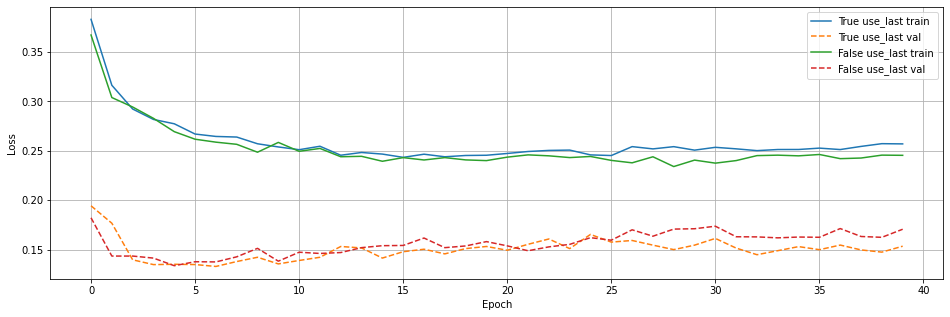

In [52]:
plt.figure(figsize = (16,5))
for i in range(2):
    use_last = 'True'
    if i != 0:
      use_last = 'False'
    plt.plot(losses_train[i],'-',label = f'{use_last} use_last train')
    plt.plot(losses_test[i],'--',label = f'{use_last} use_last val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show() 

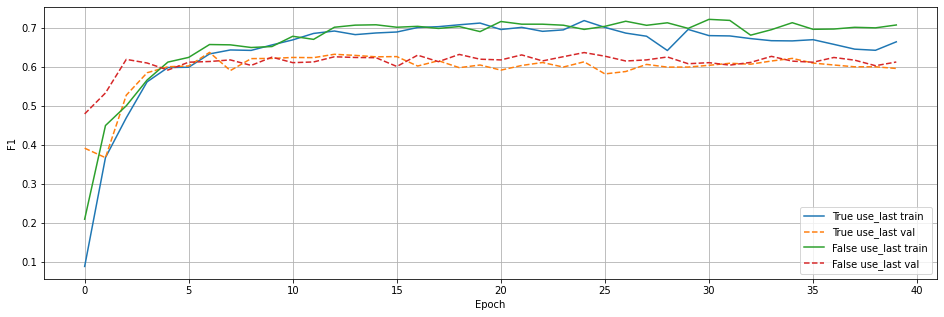

In [53]:
plt.figure(figsize = (16,5))
for i in range(2):
    use_last = 'True'
    if i != 0:
      use_last = 'False'
    plt.plot(f1_list_train[i],'-',label = f'{use_last} use_last train')
    plt.plot(f1_list_test[i],'--',label = f'{use_last} use_last val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid()
plt.show() 

Дропаут позволил убрать переобучение сети. Также лучше всего себя показывает сеть с усреднением выходов рекуррентного слоя. 

Теперь посмотрим LSTM:

In [58]:
losses_train = []
losses_test = []
f1_list_train = []
f1_list_test = []
for i in [True, False]:
  train_loader, test_loader = get_loaders(max_words=2000, max_len=20)
  model = LSTMFixedLen(vocab_size=2000, use_last=i)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = nn.BCELoss()
  train_loss_history, test_loss_history, train_f1_history, test_f1_history = learn_net(model)
  losses_train.append(train_loss_history)
  losses_test.append(test_loss_history)
  f1_list_train.append(train_f1_history)
  f1_list_test.append(test_f1_history)

Epoch [1/20]. Step [44/44]. Loss: 0.271. F1: 0.020. Test loss: 0.246. Test F1: 0.107
Epoch [2/20]. Step [44/44]. Loss: 0.237. F1: 0.200. Test loss: 0.218. Test F1: 0.291
Epoch [3/20]. Step [44/44]. Loss: 0.187. F1: 0.321. Test loss: 0.180. Test F1: 0.304
Epoch [4/20]. Step [44/44]. Loss: 0.142. F1: 0.451. Test loss: 0.160. Test F1: 0.533
Epoch [5/20]. Step [44/44]. Loss: 0.113. F1: 0.655. Test loss: 0.150. Test F1: 0.573
Epoch [6/20]. Step [44/44]. Loss: 0.093. F1: 0.728. Test loss: 0.166. Test F1: 0.605
Epoch [7/20]. Step [44/44]. Loss: 0.076. F1: 0.791. Test loss: 0.161. Test F1: 0.616
Epoch [8/20]. Step [44/44]. Loss: 0.066. F1: 0.818. Test loss: 0.177. Test F1: 0.617
Epoch [9/20]. Step [44/44]. Loss: 0.061. F1: 0.835. Test loss: 0.195. Test F1: 0.622
Epoch [10/20]. Step [44/44]. Loss: 0.055. F1: 0.852. Test loss: 0.183. Test F1: 0.609
Epoch [11/20]. Step [44/44]. Loss: 0.048. F1: 0.875. Test loss: 0.185. Test F1: 0.604
Epoch [12/20]. Step [44/44]. Loss: 0.041. F1: 0.892. Test loss:

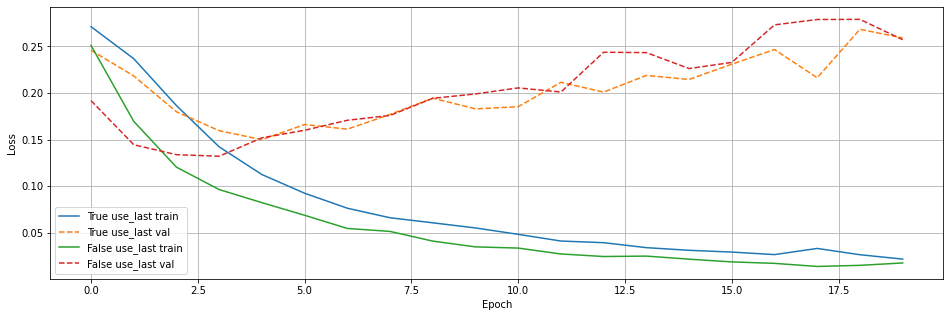

In [59]:
plt.figure(figsize = (16,5))
for i in range(2):
    use_last = 'True'
    if i != 0:
      use_last = 'False'
    plt.plot(losses_train[i],'-',label = f'{use_last} use_last train')
    plt.plot(losses_test[i],'--',label = f'{use_last} use_last val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show() 

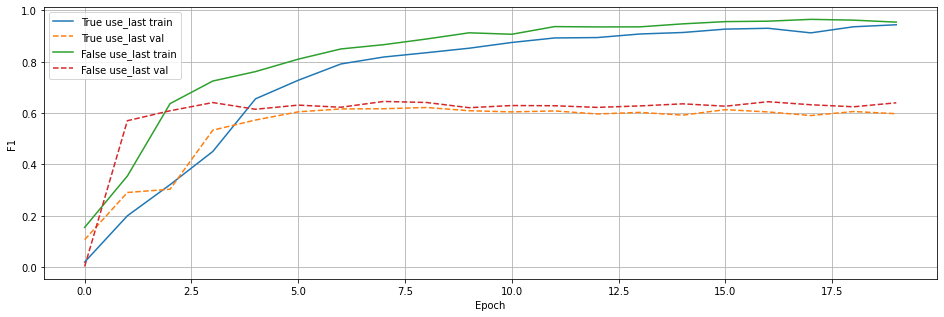

In [60]:
plt.figure(figsize = (16,5))
for i in range(2):
    use_last = 'True'
    if i != 0:
      use_last = 'False'
    plt.plot(f1_list_train[i],'-',label = f'{use_last} use_last train')
    plt.plot(f1_list_test[i],'--',label = f'{use_last} use_last val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid()
plt.show() 

Также усреднение выходов рекуррентного слоя дает лучший результат. Разнице в метрике по сравнению с GRU особо никакой нет - у GRU был максимум f1 64.9%, у LSTM - 64.5%

Попробуем также изменить длину последовательности:

In [62]:
losses_train = []
losses_test = []
f1_list_train = []
f1_list_test = []
for i in [5, 10, 15, 20]:
  train_loader, test_loader = get_loaders(max_words=2000, max_len=i)
  model = LSTMFixedLen(vocab_size=2000, use_last=False)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = nn.BCELoss()
  train_loss_history, test_loss_history, train_f1_history, test_f1_history = learn_net(model)
  losses_train.append(train_loss_history)
  losses_test.append(test_loss_history)
  f1_list_train.append(train_f1_history)
  f1_list_test.append(test_f1_history)

Epoch [1/20]. Step [44/44]. Loss: 0.250. F1: 0.119. Test loss: 0.190. Test F1: 0.306
Epoch [2/20]. Step [44/44]. Loss: 0.166. F1: 0.383. Test loss: 0.168. Test F1: 0.444
Epoch [3/20]. Step [44/44]. Loss: 0.133. F1: 0.546. Test loss: 0.171. Test F1: 0.453
Epoch [4/20]. Step [44/44]. Loss: 0.111. F1: 0.638. Test loss: 0.188. Test F1: 0.484
Epoch [5/20]. Step [44/44]. Loss: 0.089. F1: 0.730. Test loss: 0.207. Test F1: 0.524
Epoch [6/20]. Step [44/44]. Loss: 0.073. F1: 0.787. Test loss: 0.218. Test F1: 0.522
Epoch [7/20]. Step [44/44]. Loss: 0.056. F1: 0.844. Test loss: 0.232. Test F1: 0.536
Epoch [8/20]. Step [44/44]. Loss: 0.045. F1: 0.882. Test loss: 0.278. Test F1: 0.534
Epoch [9/20]. Step [44/44]. Loss: 0.042. F1: 0.894. Test loss: 0.265. Test F1: 0.534
Epoch [10/20]. Step [44/44]. Loss: 0.035. F1: 0.911. Test loss: 0.272. Test F1: 0.543
Epoch [11/20]. Step [44/44]. Loss: 0.030. F1: 0.922. Test loss: 0.303. Test F1: 0.544
Epoch [12/20]. Step [44/44]. Loss: 0.026. F1: 0.935. Test loss:

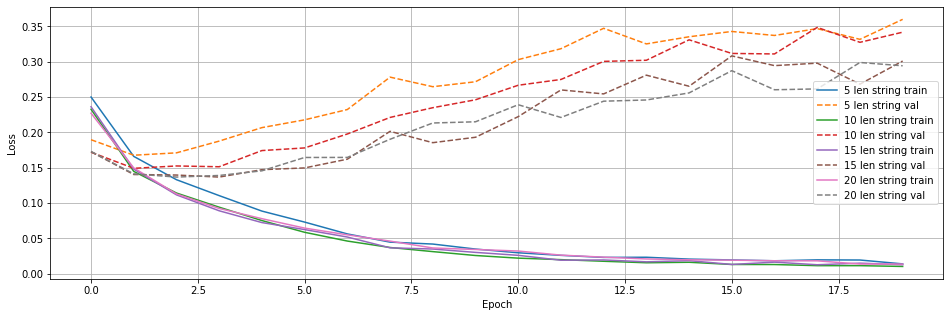

In [63]:
plt.figure(figsize = (16,5))
for i in range(4):
    plt.plot(losses_train[i],'-',label = f'{(i + 1) * 5} len string train')
    plt.plot(losses_test[i],'--',label = f'{(i + 1) * 5} len string val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show() 

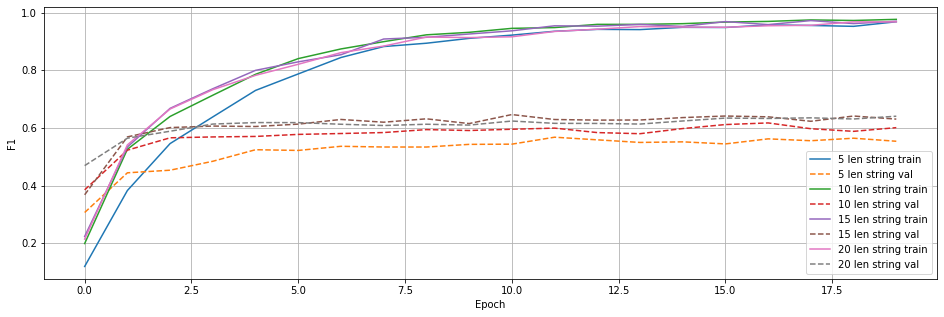

In [64]:
plt.figure(figsize = (16,5))
for i in range(4):
    plt.plot(f1_list_train[i],'-',label = f'{(i + 1) * 5} len string train')
    plt.plot(f1_list_test[i],'--',label = f'{(i + 1) * 5} len string val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid()
plt.show() 

Лучшую метрику дает последовательность в 15 токенов.

Чтобы снизить переобучение, включим слой дропаут в выходной полносвязный слой:

In [70]:
class LSTMFixedLen2(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.4)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        out = self.dropout(out)
        # print(out.shape)
        return torch.sigmoid(out)

In [71]:
losses_train = []
losses_test = []
f1_list_train = []
f1_list_test = []
for i in [True, False]:
  train_loader, test_loader = get_loaders(max_words=2000, max_len=15)
  model = LSTMFixedLen2(vocab_size=2000, use_last=i)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  criterion = nn.BCELoss()
  train_loss_history, test_loss_history, train_f1_history, test_f1_history = learn_net(model, epochs=40)
  losses_train.append(train_loss_history)
  losses_test.append(test_loss_history)
  f1_list_train.append(train_f1_history)
  f1_list_test.append(test_f1_history)

Epoch [1/40]. Step [44/44]. Loss: 0.442. F1: 0.029. Test loss: 0.273. Test F1: 0.119
Epoch [2/40]. Step [44/44]. Loss: 0.410. F1: 0.091. Test loss: 0.222. Test F1: 0.167
Epoch [3/40]. Step [44/44]. Loss: 0.389. F1: 0.236. Test loss: 0.253. Test F1: 0.479
Epoch [4/40]. Step [44/44]. Loss: 0.374. F1: 0.348. Test loss: 0.163. Test F1: 0.481
Epoch [5/40]. Step [44/44]. Loss: 0.356. F1: 0.429. Test loss: 0.151. Test F1: 0.558
Epoch [6/40]. Step [44/44]. Loss: 0.354. F1: 0.469. Test loss: 0.143. Test F1: 0.579
Epoch [7/40]. Step [44/44]. Loss: 0.344. F1: 0.499. Test loss: 0.145. Test F1: 0.569
Epoch [8/40]. Step [44/44]. Loss: 0.340. F1: 0.500. Test loss: 0.140. Test F1: 0.596
Epoch [9/40]. Step [44/44]. Loss: 0.337. F1: 0.512. Test loss: 0.147. Test F1: 0.601
Epoch [10/40]. Step [44/44]. Loss: 0.332. F1: 0.551. Test loss: 0.135. Test F1: 0.618
Epoch [11/40]. Step [44/44]. Loss: 0.330. F1: 0.545. Test loss: 0.142. Test F1: 0.623
Epoch [12/40]. Step [44/44]. Loss: 0.329. F1: 0.562. Test loss:

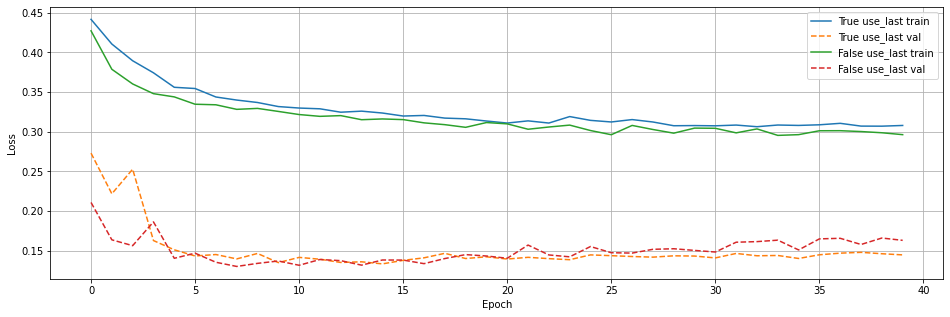

In [72]:
plt.figure(figsize = (16,5))
for i in range(2):
    use_last = 'True'
    if i != 0:
      use_last = 'False'
    plt.plot(losses_train[i],'-',label = f'{use_last} use_last train')
    plt.plot(losses_test[i],'--',label = f'{use_last} use_last val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()

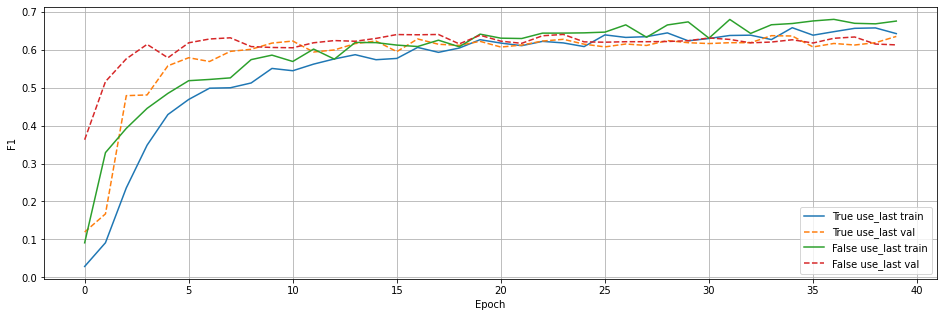

In [73]:
plt.figure(figsize = (16,5))
for i in range(2):
    use_last = 'True'
    if i != 0:
      use_last = 'False'
    plt.plot(f1_list_train[i],'-',label = f'{use_last} use_last train')
    plt.plot(f1_list_test[i],'--',label = f'{use_last} use_last val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid()
plt.show() 

Удалось полностью убрать переобучение. Усреднение выходов рекуррентного слоя по прежнему лучше. Применение дропаута выходного слоя, как и в случае с GRU, на несколько тысячных снижает метрику на тесте. Здесь максимальная метрика - 64%, без дропаута было 64.5%

**Выводы:**


*   В рекуррентных сетях важна длина последовательности.
*   Для данной задачи GRU дает на несколько тысячных больше по метрике на тесте.


*   Дропаут выходного слоя сокращает переобучение, но метрика на тесте так же немного падает.
*   Также были применены изменения отсечек, но максимум был при 0.5, и разница метрики при измении отсечки была невелика. Поэтому этот анализ не представлен.



